## This is the baseline script for reservoir

## ## Don't rename! Don't delete the output of the cells! The output shows that when Experiment_error_infeasible: Self detect occured, we use the return DeBug_Lists to run again, it will succeed! So it might be worth do run the simulation again!

In [1]:
# magic lines that avoid re-start 
%load_ext autoreload
%autoreload 2
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize,sys
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl

In [2]:
########################     Global settings!!!
rows_per_file = 3;  Scan_end_end = 12;
purpose_i = "Full_Exp_9_3Ts"

On_HPC =  False  
Runshort  =   True                    # a long run or a quick test



if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 1; # manually specify
Scan_start = (i_bundle-1)*rows_per_file+1;    
Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
# interpetation: Simnon suggested, with cracking activation, heat transfer
para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters


if On_HPC:                          # Run on HPC
    Path_csv = f"InputData/{purpose_i}/" 
    Path_NiallDMA = "InputData/" 
    BasicPath=os.getcwd() 
    Para_file = Path_csv +  para_csv
else:
    import sys  
    str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
    str_path_1 = os.path.abspath(
        os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
    sys.path.append(str_path_1) 
    Path_NiallDMA = os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
    BasicPath =  os.path.expanduser(
        "~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
    Para_file = BasicPath+f'/Get_Random_sets2/{purpose_i}/'+para_csv
    
if not os.path.exists(BasicPath +"/"+ purpose):
    os.mkdir(BasicPath +"/"+ purpose);
# import all functions 
from Fun_P2 import * 

# Load the random file
parameter_names, combinations = load_combinations_from_csv(Para_file)


pool_no = len(combinations)
Indexs  = np.arange(Scan_start-1,Scan_end)
index_list = Indexs+1
""" para_dict_Same = {
   "Total ageing cycles":int(tot_cyc), # 
   "Ageing cycles between RPT":int(cyc_age), # 
   "Update cycles for ageing": int(cyc_age),
} """
# Get all para
Para_dict_list = []
# get all dictionaries
for combination in combinations:
    input_dict = {}
    for parameter_name,para_value in zip(parameter_names,combination ):
        input_dict[parameter_name] = para_value
    Para_dict_list.append(input_dict)
print(f"Total scan case is {len(Para_dict_list)}")

Total scan case is 3


In [3]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]
# Update 23-06-17 
#   para="Total heat transfer coefficient [W.m-2.K-1]";
#   output="Volume-averaged cell temperature [C]"
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    "CCend Negative electrode surface potential difference [V]",
    "CCend SEI film overpotential [V]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Negative electrode surface potential difference [V]",
    "CDend SEI film overpotential [V]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list[0].keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %",
    "Error Res %","Error ageT %","Punish",
    "Dry out",]

head_pos = [ 
    "Total ageing cycles","Ageing cycles between RPT",
    "Update cycles for ageing",
    "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)   
Exp_pack = [
    Exp_All_Cell,Temp_Cell_Exp_All,
    Exp_Path,Exp_head,Exp_Temp_Cell,
    book_name_xlsx,]  
# remaining set-up for experiment and create folders

if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");

Successfully create a excel file


In [4]:
print(Para_dict_list[0]) # initial mesh: [5,5,5,60,20]
# Para_dict_list[0][ 'Mesh list'] = '[5,5,5,60,20]'
# run record
# 1-'[10,10,10,100,20]' - 1 hour every 26 ageing cycles

{'Scan No': 1, 'Exp No.': 9, 'Ageing temperature': 5.0, 'Mesh list': '[5,5,5,60,20]', 'Inner SEI lithium interstitial diffusivity [m2.s-1]': 9.81e-19, 'Dead lithium decay constant [s-1]': 1e-07, 'Lithium plating kinetic rate constant [m.s-1]': 1e-10, 'Negative electrode LAM constant proportional term [s-1]': 2.84e-09, 'Positive electrode LAM constant proportional term [s-1]': 2.98e-18, 'Negative electrode cracking rate': 5.29e-25, 'Outer SEI partial molar volume [m3.mol-1]': 5.22e-05, 'SEI growth activation energy [J.mol-1]': 10000.0, 'Negative cracking growth activation energy [J.mol-1]': 0.0, 'Negative electrode diffusivity activation energy [J.mol-1]': 17000.0, 'Positive electrode diffusivity activation energy [J.mol-1]': 12000.0, 'Contact resistance [Ohm]': 0.0115, 'Total heat transfer coefficient [W.m-2.K-1]': 20, 'Initial electrolyte excessive amount ratio': 1.0, 'Cycles within RPT': 1, 'RPT temperature': 25, 'Para_Set': 'OKane2023', 'Model option': "{'SEI': 'interstitial-diffusi

In [5]:
fs = 13; dpi = 100;
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=False;  
Return_Sol=True;   Check_Small_Time=True; R_from_GITT = False
Runshort = False
midc_merge,Sol_RPT,Sol_AGE,DeBug_Lists = Run_P2_Excel (
    Para_dict_list[0],BasicPath, Path_NiallDMA, 
    purpose,    Exp_pack, keys_all,dpi,fs,
    Runshort,   Plot_Exp,Timeout,Return_Sol,
    Check_Small_Time, R_from_GITT
) 


Start Now! Scan 1.
Has Overwritten Initial outer SEI thickness [m] to be 6.73e-09 and Negative electrode porosity to be 0.235 to account for initial capacity loss of 0.135 Ah
Scan 1: DryOut = On
Initial electrolyte amount is  5.236163896909271 mL
Scan 1: Spent 19.224 ms on Initialization
Scan 1: Finish break-in cycle within 2 minutes, 8 seconds
Fail to read Throughput capacity for the 1th time
Scan 1: Finish post-process for break-in cycle within 1.369 s
Electrolyte is being squeezed out, check plated lithium (active and dead)


At t = 71.3421 and h = 4.23511e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 71.3428 and h = 4.84122e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 71.3428 and h = 3.29871e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 539.816 and h = 9.28322e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.815 and h = 5.16379e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.8169 and h = 2.65713e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.8168 and h = 6.87827e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 539.558 and h = 3.16665e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.558 and h = 4.81703e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.558 and h = 4.24539e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 1: Finish for No.0 ageing cycles within 46 minutes, 34 seconds
Scan 1: Finish post-process for No.78 ageing cycles within 550.947 ms


At t = 294.613 and h = 1.74316e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 294.615 and h = 1.45439e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 144.615 and h = 7.44279e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 286.056 and h = 1.20067e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 286.056 and h = 1.1393e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 136.056 and h = 7.52235e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.78 RPT cycles within 2 minutes, 14 seconds
Scan 1: Finish post-process for No.78 RPT cycles within 863.090 ms


At t = 504.627 and h = 7.50668e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 504.395 and h = 7.72477e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 504.165 and h = 7.05403e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.934 and h = 8.15051e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.704 and h = 5.46706e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.474 and h = 3.97584e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.244 and h = 6.62844e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 503.015 and h = 1.8422e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 502.786 and h = 3.70718e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 502.557 and h = 9.28101e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 1: Finish for No.78 ageing cycles within 43 minutes, 29 seconds
Scan 1: Finish post-process for No.156 ageing cycles within 195.696 ms


At t = 222.666 and h = 1.13486e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 222.666 and h = 3.18343e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 214.139 and h = 1.6444e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 214.139 and h = 2.84936e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.156 RPT cycles within 2 minutes, 0 seconds
Scan 1: Finish post-process for No.156 RPT cycles within 766.765 ms


At t = 529.862 and h = 7.25363e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 49.8622 and h = 4.93726e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 49.861 and h = 1.87762e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 49.8621 and h = 7.12837e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 469.441 and h = 6.94265e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 229.441 and h = 3.93556e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 109.441 and h = 6.15753e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 469.231 and h = 9.72796e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 229.229 and h = 5.53129e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 109.231 and h = 3.68216e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 1: Finish for No.156 ageing cycles within 51 minutes, 33 seconds
Scan 1: Finish post-process for No.234 ageing cycles within 213.955 ms


At t = 157.629 and h = 1.1149e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 157.63 and h = 1.91772e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.122 and h = 1.42454e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.118 and h = 1.19592e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.118 and h = 1.19568e-14, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.234 RPT cycles within 2 minutes, 12 seconds
Scan 1: Finish post-process for No.234 RPT cycles within 856.143 ms


At t = 498.057 and h = 7.88912e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 437.653 and h = 2.40842e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 197.654 and h = 1.40757e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.6538 and h = 1.22414e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 437.46 and h = 4.64364e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 197.46 and h = 4.08124e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.4592 and h = 4.00164e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 437.266 and h = 4.18212e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 197.267 and h = 1.33222e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 77.266 and h = 7.71877e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 1: Finish for No.234 ageing cycles within 50 minutes, 48 seconds
Scan 1: Finish post-process for No.312 ageing cycles within 231.313 ms


At t = 488.665 and h = 8.63546e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 97.7477 and h = 4.42562e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 97.7477 and h = 1.82784e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 97.7477 and h = 2.32821e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.261 and h = 3.77321e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.2612 and h = 1.15751e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 89.258 and h = 7.80171e-15, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.312 RPT cycles within 2 minutes, 17 seconds
Scan 1: Finish post-process for No.312 RPT cycles within 835.929 ms


At t = 468.791 and h = 6.72935e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.794 and h = 7.35436e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.794 and h = 2.79315e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 408.404 and h = 2.65475e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 168.404 and h = 2.74542e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 408.222 and h = 4.5188e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 168.223 and h = 1.04515e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 408.042 and h = 3.82243e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 168.041 and h = 1.0977e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 407.861 and h = 5.21694e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 1: Finish for No.312 ageing cycles within 48 minutes, 16 seconds
Scan 1: Finish post-process for No.390 ageing cycles within 197.042 ms
Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.390 RPT cycles within 1 minute, 53 seconds
Scan 1: Finish post-process for No.390 RPT cycles within 735.244 ms


At t = 441.523 and h = 9.56885e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 201.524 and h = 7.99695e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 80.1987 and h = 1.20167e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 381.143 and h = 7.47869e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 141.144 and h = 5.17766e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 380.973 and h = 2.87286e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 140.973 and h = 9.13625e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 380.802 and h = 4.95803e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 140.802 and h = 8.42351e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 380.631 and h = 6.31541e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.390 ageing cycles within 45 minutes, 10 seconds
Scan 1: Finish post-process for No.468 ageing cycles within 182.851 ms


At t = 476.449 and h = 8.80829e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 349.359 and h = 4.66258e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 340.924 and h = 3.59633e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.468 RPT cycles within 2 minutes, 1 second
Scan 1: Finish post-process for No.468 RPT cycles within 899.159 ms


At t = 415.872 and h = 5.17071e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 175.872 and h = 5.73811e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 55.8709 and h = 5.9062e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 55.8724 and h = 6.41391e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 355.491 and h = 3.47633e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.491 and h = 1.02986e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.491 and h = 4.08565e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 55.4918 and h = 1.1064e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 355.328 and h = 6.47334e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.329 and h = 1.07825e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 1: Finish for No.468 ageing cycles within 53 minutes, 7 seconds
Scan 1: Finish post-process for No.546 ageing cycles within 195.464 ms


At t = 299.46 and h = 3.87187e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 299.459 and h = 2.63666e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.46 and h = 1.31312e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 291.051 and h = 1.45032e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 291.051 and h = 2.31351e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 141.049 and h = 5.16506e-15, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.546 RPT cycles within 2 minutes, 14 seconds
Scan 1: Finish post-process for No.546 RPT cycles within 789.712 ms


At t = 391.525 and h = 5.45965e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 151.525 and h = 4.25326e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 331.143 and h = 3.51925e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.1428 and h = 5.3618e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 91.1429 and h = 5.90661e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 330.986 and h = 7.32252e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.9862 and h = 6.47601e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.9857 and h = 1.98954e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 330.83 and h = 4.58868e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.8296 and h = 6.34673e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 1: Finish for No.546 ageing cycles within 46 minutes, 43 seconds
Scan 1: Finish post-process for No.624 ageing cycles within 176.215 ms


At t = 399.375 and h = 1.03694e-08, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 251.88 and h = 5.49565e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 251.877 and h = 6.91929e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.878 and h = 9.6154e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.498 and h = 2.97839e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.495 and h = 1.88436e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.4982 and h = 1.94376e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.624 RPT cycles within 2 minutes, 4 seconds
Scan 1: Finish post-process for No.624 RPT cycles within 741.629 ms


At t = 368.318 and h = 1.09596e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 128.318 and h = 4.01916e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 307.936 and h = 9.76381e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.9352 and h = 6.42386e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.9367 and h = 5.92461e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 307.786 and h = 6.184e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.7861 and h = 3.90727e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.7861 and h = 5.03493e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 307.635 and h = 3.70348e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 67.6359 and h = 2.26623e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 1: Finish for No.624 ageing cycles within 50 minutes, 14 seconds
Scan 1: Finish post-process for No.702 ageing cycles within 202.773 ms


At t = 206.332 and h = 2.54977e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 206.332 and h = 1.27162e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 197.98 and h = 7.61987e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 197.98 and h = 1.20004e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.702 RPT cycles within 2 minutes, 8 seconds
Scan 1: Finish post-process for No.702 RPT cycles within 779.054 ms


At t = 346.111 and h = 5.65367e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 106.111 and h = 7.06278e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 106.111 and h = 4.34897e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.73 and h = 2.54782e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.585 and h = 4.41803e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.44 and h = 5.50894e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.295 and h = 1.04047e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.15 and h = 1.88953e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 285.005 and h = 1.30149e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 284.86 and h = 4.19307e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t

Scan 1: Finish for No.702 ageing cycles within 43 minutes, 31 seconds
Scan 1: Finish post-process for No.780 ageing cycles within 181.026 ms


At t = 162.577 and h = 1.43426e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 162.577 and h = 2.1244e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 154.253 and h = 1.99023e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 154.253 and h = 2.37015e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.780 RPT cycles within 1 minute, 52 seconds
Scan 1: Finish post-process for No.780 RPT cycles within 770.307 ms


At t = 324.784 and h = 4.4466e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.784 and h = 1.06895e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.7841 and h = 5.95687e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 264.404 and h = 6.7508e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 264.263 and h = 1.55789e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 264.123 and h = 1.73521e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 263.982 and h = 7.1426e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 263.842 and h = 6.67764e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 263.702 and h = 3.28104e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 263.562 and h = 6.13041e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t

Scan 1: Finish for No.780 ageing cycles within 42 minutes, 15 seconds
Scan 1: Finish post-process for No.858 ageing cycles within 184.149 ms


At t = 120.356 and h = 1.37568e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 120.355 and h = 5.85081e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 120.357 and h = 1.59921e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.061 and h = 1.74171e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.062 and h = 5.67308e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.062 and h = 9.77767e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.858 RPT cycles within 2 minutes, 8 seconds
Scan 1: Finish post-process for No.858 RPT cycles within 862.975 ms


At t = 304.209 and h = 1.34215e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 64.2102 and h = 2.33927e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 64.2102 and h = 4.86095e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.821 and h = 1.35146e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.686 and h = 1.11229e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.549 and h = 3.68414e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.413 and h = 3.40199e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.276 and h = 1.01326e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.14 and h = 6.36003e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.003 and h = 8.12058e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 1: Finish for No.858 ageing cycles within 50 minutes, 45 seconds
Scan 1: Finish post-process for No.936 ageing cycles within 185.120 ms


At t = 79.5166 and h = 9.89999e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 79.5113 and h = 2.30853e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 79.5148 and h = 6.79244e-15, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.936 RPT cycles within 2 minutes, 6 seconds
Scan 1: Finish post-process for No.936 RPT cycles within 801.649 ms


At t = 284.316 and h = 3.14601e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.927 and h = 5.1044e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.927 and h = 3.78941e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.927 and h = 3.30676e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.793 and h = 1.16518e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.794 and h = 2.88127e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.794 and h = 1.26327e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.661 and h = 9.5163e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 223.661 and h = 5.15356e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 103.661 and h = 3.78729e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 1: Finish for No.936 ageing cycles within 48 minutes, 2 seconds
Scan 1: Finish post-process for No.1014 ageing cycles within 205.802 ms


At t = 519.785 and h = 1.26089e-10, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1014 RPT cycles within 1 minute, 56 seconds
Scan 1: Finish post-process for No.1014 RPT cycles within 776.633 ms


At t = 265.049 and h = 4.55464e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.651 and h = 5.51885e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.65 and h = 5.55268e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.6506 and h = 4.83106e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.521 and h = 1.76513e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.521 and h = 1.07677e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.5204 and h = 3.44535e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.391 and h = 4.43564e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 204.391 and h = 2.01556e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.391 and h = 4.95786e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 1: Finish for No.1014 ageing cycles within 50 minutes, 6 seconds
Scan 1: Finish post-process for No.1092 ageing cycles within 200.830 ms


At t = 353.3 and h = 3.85666e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1092 RPT cycles within 2 minutes, 3 seconds
Scan 1: Finish post-process for No.1092 RPT cycles within 750.396 ms


At t = 246.33 and h = 8.55606e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.924 and h = 5.28669e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.924 and h = 6.24884e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 65.9236 and h = 1.13725e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.797 and h = 8.80345e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.796 and h = 4.20408e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 65.7967 and h = 8.71041e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.67 and h = 1.17568e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 185.67 and h = 3.45665e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 65.6702 and h = 1.18697e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 1: Finish for No.1092 ageing cycles within 46 minutes, 50 seconds
Scan 1: Finish post-process for No.1170 ageing cycles within 202.300 ms


At t = 324.039 and h = 1.34861e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 315.868 and h = 1.97735e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1170 RPT cycles within 2 minutes, 0 seconds
Scan 1: Finish post-process for No.1170 RPT cycles within 785.414 ms


At t = 228.094 and h = 4.74e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 228.094 and h = 4.31699e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.095 and h = 6.5671e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 48.0938 and h = 5.05218e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 167.675 and h = 4.77763e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 167.675 and h = 6.95286e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 47.6745 and h = 1.23882e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 47.6751 and h = 1.29496e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 167.55 and h = 5.66355e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 167.55 and h = 5.52901e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

Scan 1: Finish for No.1170 ageing cycles within 45 minutes, 29 seconds
Scan 1: Finish post-process for No.1248 ageing cycles within 201.791 ms


At t = 486.395 and h = 1.38855e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 287.486 and h = 1.23774e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 287.486 and h = 1.17029e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 137.482 and h = 1.06143e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 279.339 and h = 1.26239e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 279.339 and h = 2.06546e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 129.339 and h = 9.39541e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1248 RPT cycles within 2 minutes, 19 seconds
Scan 1: Finish post-process for No.1248 RPT cycles within 734.146 ms


At t = 210.302 and h = 4.45684e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 210.302 and h = 4.16103e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 90.3017 and h = 1.13149e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.878 and h = 4.73919e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.878 and h = 1.13914e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.756 and h = 1.8259e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.756 and h = 2.12074e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.634 and h = 8.78384e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.634 and h = 1.32649e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.512 and h = 5.54949e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 1: Finish for No.1248 ageing cycles within 46 minutes, 10 seconds
Scan 1: Finish post-process for No.1326 ageing cycles within 184.220 ms


At t = 251.829 and h = 1.01803e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 251.824 and h = 1.82336e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 101.829 and h = 1.23764e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.713 and h = 9.25685e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 243.712 and h = 1.52504e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 93.7125 and h = 6.76671e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1326 RPT cycles within 2 minutes, 4 seconds
Scan 1: Finish post-process for No.1326 RPT cycles within 694.994 ms


At t = 192.953 and h = 3.06982e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 192.953 and h = 4.74665e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 71.3972 and h = 1.84654e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.524 and h = 6.08754e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.523 and h = 4.0053e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.404 and h = 1.21339e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.404 and h = 7.2295e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.285 and h = 5.90835e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.285 and h = 1.15913e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 132.166 and h = 5.45806e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 1: Finish for No.1326 ageing cycles within 43 minutes, 2 seconds
Scan 1: Finish post-process for No.1404 ageing cycles within 171.182 ms


At t = 217.014 and h = 7.68781e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 217.013 and h = 2.06264e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 208.927 and h = 1.6066e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 208.927 and h = 1.71513e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1404 RPT cycles within 1 minute, 56 seconds
Scan 1: Finish post-process for No.1404 RPT cycles within 712.294 ms


At t = 176.017 and h = 6.15673e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 176.018 and h = 8.25079e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.0179 and h = 4.64337e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 56.0177 and h = 1.213e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.583 and h = 7.63087e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.583 and h = 5.77165e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.583 and h = 5.97915e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 55.5829 and h = 1.53363e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.465 and h = 5.73406e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 115.465 and h = 7.63017e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At

Scan 1: Finish for No.1404 ageing cycles within 54 minutes, 15 seconds
Scan 1: Finish post-process for No.1482 ageing cycles within 283.387 ms


At t = 493.444 and h = 7.89949e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 182.98 and h = 1.00581e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 182.981 and h = 3.9529e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 174.925 and h = 2.35668e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 174.926 and h = 1.62976e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1482 RPT cycles within 2 minutes, 5 seconds
Scan 1: Finish post-process for No.1482 RPT cycles within 747.410 ms


At t = 159.467 and h = 5.28495e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 159.467 and h = 1.03236e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 99.0215 and h = 9.48983e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 99.0215 and h = 1.15095e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 99.0216 and h = 3.8384e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.9046 and h = 1.19524e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.9053 and h = 3.03929e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.9059 and h = 1.3817e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.7913 and h = 3.8713e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 98.7912 and h = 6.53626e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At 

Scan 1: Finish for No.1482 ageing cycles within 48 minutes, 31 seconds
Scan 1: Finish post-process for No.1560 ageing cycles within 174.077 ms


At t = 149.621 and h = 9.03951e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.621 and h = 1.60295e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 149.621 and h = 1.36414e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 74.6209 and h = 1.04934e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 141.595 and h = 1.74283e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 141.595 and h = 1.44736e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 141.595 and h = 2.45755e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1560 RPT cycles within 2 minutes, 13 seconds
Scan 1: Finish post-process for No.1560 RPT cycles within 750.334 ms


At t = 143.246 and h = 1.58192e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 143.246 and h = 3.51928e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.7729 and h = 6.1314e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.7728 and h = 5.729e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.7727 and h = 4.52989e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.6584 and h = 6.87059e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.6584 and h = 4.48569e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.6586 and h = 1.5263e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.5442 and h = 5.83006e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 82.5443 and h = 8.15174e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t

Scan 1: Finish for No.1560 ageing cycles within 49 minutes, 48 seconds
Scan 1: Finish post-process for No.1638 ageing cycles within 176.804 ms


At t = 116.78 and h = 1.04482e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 116.781 and h = 1.64194e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 116.781 and h = 3.80369e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.787 and h = 1.98689e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.787 and h = 1.29363e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 108.787 and h = 1.65674e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1638 RPT cycles within 2 minutes, 6 seconds
Scan 1: Finish post-process for No.1638 RPT cycles within 736.086 ms


At t = 127.281 and h = 3.34349e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 127.281 and h = 2.29851e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.7978 and h = 5.48314e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.7979 and h = 6.43153e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.7979 and h = 6.39363e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.6844 and h = 5.64909e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.6852 and h = 1.68938e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.6852 and h = 1.77906e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.5732 and h = 6.74451e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.5734 and h = 1.5891e-12, the corrector convergence failed repeatedly or with |h| = hmin.
A

Scan 1: Finish for No.1638 ageing cycles within 49 minutes, 47 seconds
Scan 1: Finish post-process for No.1716 ageing cycles within 169.488 ms


At t = 531.421 and h = 2.24887e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.575 and h = 9.18628e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.5751 and h = 8.46481e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 84.5748 and h = 1.79875e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 76.6124 and h = 1.80377e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 76.6124 and h = 1.85006e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 76.6125 and h = 1.54993e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1716 RPT cycles within 2 minutes, 4 seconds
Scan 1: Finish post-process for No.1716 RPT cycles within 688.848 ms


At t = 111.626 and h = 4.68716e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 111.626 and h = 6.59721e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 111.626 and h = 1.70205e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.6254 and h = 4.76355e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.1355 and h = 2.87788e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.1352 and h = 1.78911e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.1355 and h = 5.52172e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.1355 and h = 6.05672e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.0239 and h = 2.32347e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 51.0246 and h = 6.18696e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.1716 ageing cycles within 46 minutes, 30 seconds
Scan 1: Finish post-process for No.1794 ageing cycles within 185.971 ms


At t = 370.152 and h = 3.99216e-13, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1794 RPT cycles within 1 minute, 57 seconds
Scan 1: Finish post-process for No.1794 RPT cycles within 778.895 ms


At t = 96.2683 and h = 1.10064e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.2684 and h = 3.52815e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 96.2683 and h = 6.88871e-12, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.1794 ageing cycles within 36 minutes, 34 seconds
Scan 1: Finish post-process for No.1872 ageing cycles within 237.594 ms
Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1872 RPT cycles within 1 minute, 58 seconds
Scan 1: Finish post-process for No.1872 RPT cycles within 1.193 s


At t = 81.193 and h = 3.7061e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 81.193 and h = 3.34086e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 81.1924 and h = 2.09195e-15, the corrector convergence failed repeatedly or with |h| = hmin.


Scan 1: Finish for No.1872 ageing cycles within 35 minutes, 38 seconds
Scan 1: Finish post-process for No.1950 ageing cycles within 179.528 ms


At t = 351.458 and h = 1.76027e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 343.587 and h = 1.49597e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1950 RPT cycles within 2 minutes, 7 seconds
Scan 1: Finish post-process for No.1950 RPT cycles within 706.904 ms


At t = 66.3819 and h = 8.45397e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.3825 and h = 6.93517e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 66.3826 and h = 4.23561e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 59.9765 and h = 1.97032e-11, the corrector convergence failed repeatedly or with |h| = hmin.
2023-12-02 12:15:24.364 - [ERROR] callbacks.on_experiment_error(224): Simulation error: Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'F' [IdasInterface] at .../casadi/core/function.cpp:330:
.../casadi/interfaces/sundials/idas_interface.cpp:596: IDASolve returned "IDA_CONV_FAIL". Consult IDAS documentation.


Experiment_error_infeasible: Self detect
Fail due to Experiment error or infeasible
Scan 1: Fail during No.1950 ageing cycles within 18 minutes, 22 seconds due to Experiment error or infeasible


At t = 351.078 and h = 2.23813e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 343.207 and h = 2.91565e-11, the corrector convergence failed repeatedly or with |h| = hmin.


Fail to read Throughput capacity for the 1th time
Scan 1: Finish for No.1950 RPT cycles within 1 minute, 56 seconds
Scan 1: Finish post-process for No.1950 RPT cycles within 663.121 ms
Scan 1: Getting extra variables within 112.900 us
Scan 1: Finish all plots within 6.132 s
Successfully create a excel file
Scan 1: Successfully save json file!
Scan 1: Successfully save mat file!
Scan 1: Try saving within 174.695 ms
Succeed doing something in 20 hours, 48 minutes, 1 second
This is the end of No. 1  scan


### debug part

In [16]:
[DeBug_List_RPT,DeBug_List_AGE] = DeBug_Lists
[
    Model, Model_new, Call_RPT, Simnew,   Sol , Sol_new, Para_update, ModelExperiment, 
    Update_Cycles,Temper_i ,mesh_list,submesh_strech, var_pts,
    submesh_types,  list_short, dict_short, 
] = DeBug_List_AGE

In [22]:
class RioCallback(pb.callbacks.Callback):
    def __init__(self, logfile=None):
        self.logfile = logfile
        self.success  = True
        if logfile is None:
            # Use pybamm's logger, which prints to command line
            self.logger = pb.logger
        else:
            # Use a custom logger, this will have its own level so set it to the same
            # level as the pybamm logger (users can override this)
            self.logger = pb.get_new_logger(__name__, logfile)
            self.logger.setLevel(pb.logger.level)
    
    def on_experiment_error(self, logs):
        self.success  = False
    def on_experiment_infeasible(self, logs):
        self.success  = False
Call_Age = RioCallback()  
Simnew_2 = pb.Simulation(
    Model_new,
    experiment = ModelExperiment, 
    parameter_values=Para_update, 
    solver = pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts = var_pts,
    submesh_types=submesh_types
)
Sol_new_2 = Simnew_2.solve(
    calc_esoh=False,
    save_at_cycles = Update_Cycles,
    callbacks=Call_Age,)

At t = 112.019 and h = 5.10723e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.019 and h = 4.6812e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.019 and h = 1.3333e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 52.0192 and h = 8.5301e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.2709 and h = 1.10665e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.2708 and h = 1.43043e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.271 and h = 5.4113e-13, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.2708 and h = 1.13473e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.1991 and h = 2.4125e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.1989 and h = 9.96374e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t =

In [54]:
# solution 1: break one step into 2 and add control on time steps
exp_AGE_text_3 = [(
    "Discharge at 1C until 2.6V", 
    "Discharge at 1C until 2.5V (3 seconds period)", 
    "Charge at 0.3C until 3.3V (3 seconds period)",
    "Charge at 0.3C until 4.2V",
    "Hold at 4.2 V until C/100",
    ),  ]  # *  78
Experiment_Long_3   = pb.Experiment( exp_AGE_text_3 * Update_Cycles  )  
Simnew_3 = pb.Simulation(
    Model_new,
    experiment = Experiment_Long_3, 
    parameter_values=Para_update, 
    solver = pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts = var_pts,
    submesh_types=submesh_types
)
Sol_new_3 = Simnew_3.solve(
    calc_esoh=False,
    save_at_cycles = Update_Cycles,
    callbacks=Call_Age,)

At t = 112.018 and h = 9.85932e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.019 and h = 7.24703e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.019 and h = 7.54378e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 52.0188 and h = 2.144e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 47.583 and h = 5.77913e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 47.583 and h = 1.09746e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 47.5828 and h = 9.4868e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 47.583 and h = 2.38253e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.2702 and h = 2.22037e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.271 and h = 6.45612e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 

In [61]:
# solution 2: add one extra rest time step for 1 second 
exp_AGE_text_4 = [(
    "Discharge at 1C until 2.5V", 
    "Rest for 1 second",
    "Charge at 0.3C until 4.2V",
    "Hold at 4.2 V until C/100",
    ),  ]  # *  78
Experiment_Long_4   = pb.Experiment( exp_AGE_text_4 * 3  )  
Simnew_4 = pb.Simulation(
    Model_new,
    experiment = Experiment_Long_4, 
    parameter_values=Para_update, 
    solver = pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts = var_pts,
    submesh_types=submesh_types
)
Sol_new_4 = Simnew_4.solve(
    calc_esoh=False,
    save_at_cycles = 3,
    callbacks=Call_Age,)

At t = 112.018 and h = 7.33207e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.019 and h = 1.04619e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.019 and h = 3.66552e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 52.0193 and h = 4.74399e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.271 and h = 4.1298e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.271 and h = 4.3018e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.2705 and h = 3.48898e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.2689 and h = 5.06067e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.1984 and h = 1.35584e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.199 and h = 5.76639e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t 

In [75]:
# solution 3: add one extra rest time step for 2 seconds
exp_AGE_text_5 = [(
    "Discharge at 1C until 2.5V", 
    "Rest for 2 seconds",
    "Charge at 0.3C until 4.2V",
    "Hold at 4.2 V until C/100",
    ),  ]  # *  78
Experiment_Long_5   = pb.Experiment( exp_AGE_text_5 * 3  )  
Simnew_5 = pb.Simulation(
    Model_new,
    experiment = Experiment_Long_5, 
    parameter_values=Para_update, 
    solver = pb.CasadiSolver(return_solution_if_failed_early=True),
    var_pts = var_pts,
    submesh_types=submesh_types
)
Sol_new_5 = Simnew_5.solve(
    calc_esoh=False,
    save_at_cycles = 3,
    callbacks=Call_Age,)

At t = 112.019 and h = 2.62502e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.018 and h = 2.61407e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 112.019 and h = 8.67561e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 52.0191 and h = 5.22749e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.271 and h = 4.1308e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.2709 and h = 2.15215e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.2704 and h = 2.43835e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.2708 and h = 8.70256e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.1991 and h = 1.44745e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 53.1984 and h = 6.43098e-15, the corrector convergence failed repeatedly or with |h| = hmin.
At

In [156]:
# try harsh cycling condition:
Para_update.update({'Edge heat transfer coefficient [W.m-2.K-1]': 0.3}, check_already_exists=False)
def Run_harsh(exp_AGE_text_i):
    Call_f = RioCallback()
    Experiment_Long_f   = pb.Experiment( exp_AGE_text_i * 1  )  
    Simnew_f = pb.Simulation(
        Model_new,
        experiment = Experiment_Long_f, 
        parameter_values=Para_update, 
        solver = pb.CasadiSolver(return_solution_if_failed_early=True),
        var_pts = var_pts,
        submesh_types=submesh_types
    )
    Sol_new_f = Simnew_f.solve(
        calc_esoh=False,
        save_at_cycles = 1,
        callbacks=Call_f,)
    return Sol_new_f

exp_rest_2CD_0p3CC_wo_Rest = [(
    "Discharge at 1C until 2.5V", 
    "Charge at 0.3C until 4.2V",
    "Hold at 4.2 V until C/100",),  ] 
exp_rest_2CD_0p3CC_w_Rest = [(
    "Discharge at 2C until 2.5V", 
    "Rest for 2 seconds",
    "Charge at 0.3C until 4.2V",
    "Hold at 4.2 V until C/100",),  ] 
Sol_new_f = Run_harsh(exp_rest_2CD_0p3CC_wo_Rest)


At t = 127.474 and h = 1.27953e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 127.473 and h = 4.76143e-15, the corrector convergence failed repeatedly or with |h| = hmin.


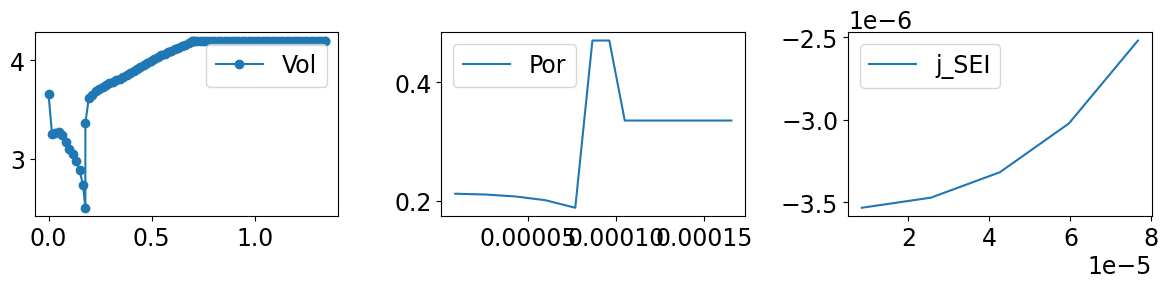

In [157]:
Plot_cyc(Sol_new_f.cycles[0])

In [27]:
def Run_Model_Base_On_Last_Solution_part(Sol_new,Sol,Update_Cycles,Call_Age):
    i_try = 0
    while i_try<3:
        try:
            getSth2 = Sol_new['Throughput capacity [A.h]'].entries[-1]
        except:
            i_try += 1
            print(f"Fail to read Throughput capacity for the {i_try}th time")
        else:
            break
    i_try = 0
    while i_try<3:
        try:
            getSth = Sol['Throughput capacity [A.h]'].entries[-1]
        except:
            i_try += 1
            print(f"Fail to read Throughput capacity for the {i_try}th time")
        else:
            break
    # update 23-11-16 change method to get throughput capacity:
    # # (1) add old ones, as before; (2): change values of the last one
    Sol_new['Throughput capacity [A.h]'].entries += getSth
    if not Update_Cycles == 1: # the solution is imcomplete in this case
        cyc_number = len(Sol_new.cycles)
        thr_1st = np.trapz(
            abs(Sol_new.cycles[0]["Current [A]"].entries), 
            Sol_new.cycles[0]["Time [h]"].entries) # in A.h
        thr_end = np.trapz(
            abs(Sol_new.cycles[-1]["Current [A]"].entries), 
            Sol_new.cycles[-1]["Time [h]"].entries) # in A.h
        thr_tot = (thr_1st+thr_end) / 2 * cyc_number
    else:
        thr_tot = abs(
            Sol_new['Throughput capacity [A.h]'].entries[-1] - 
            Sol_new['Throughput capacity [A.h]'].entries[0]  )
    Sol_new['Throughput capacity [A.h]'].entries[-1] = getSth + thr_tot # only the last one is true
    DeBug_List = "Empty"
    Result_list = [Model_new, Sol_new,Call_Age,DeBug_List]
    return Result_list
Result_list_AGE_2 = Run_Model_Base_On_Last_Solution_part(Sol_new_2,Sol,Update_Cycles,Call_Age)
[Model_Dry_2, Sol_Dry_2 , Call_Age_2,DeBug_List_AGE_2 ] = Result_list_AGE_2


78

In [150]:
def Plot_cyc(cyc_stp):
    fig, axs = plt.subplots(1,3, figsize=(12,3.2),tight_layout=True)
    axs[0].plot(
        cyc_stp["Time [h]"].entries - cyc_stp["Time [h]"].entries[0],
        cyc_stp["Terminal voltage [V]"].entries, "-o",
        label="Vol")
    #axs[0].set_xlim(0.7,0.8)
    #axs[0].set_ylim(2.45,3.5)
    axs[1].plot(
        cyc_stp["x [m]"].entries[:,-1],
        cyc_stp["Porosity"].entries[:,-1],
        label="Por")
    # "SEI interfacial current density [A.m-2]"
    axs[2].plot(
        cyc_stp["x_n [m]"].entries[:,-1],
        cyc_stp["SEI interfacial current density [A.m-2]"].entries[:,-1],
        label="j_SEI")
    for i in range(3):
        axs[i].legend()
    return 
#Plot_cyc(Sol_new_2.cycles[77])
#Plot_cyc(Sol_new_3.cycles[77])
#Plot_cyc(Sol_new_4.cycles[-1])

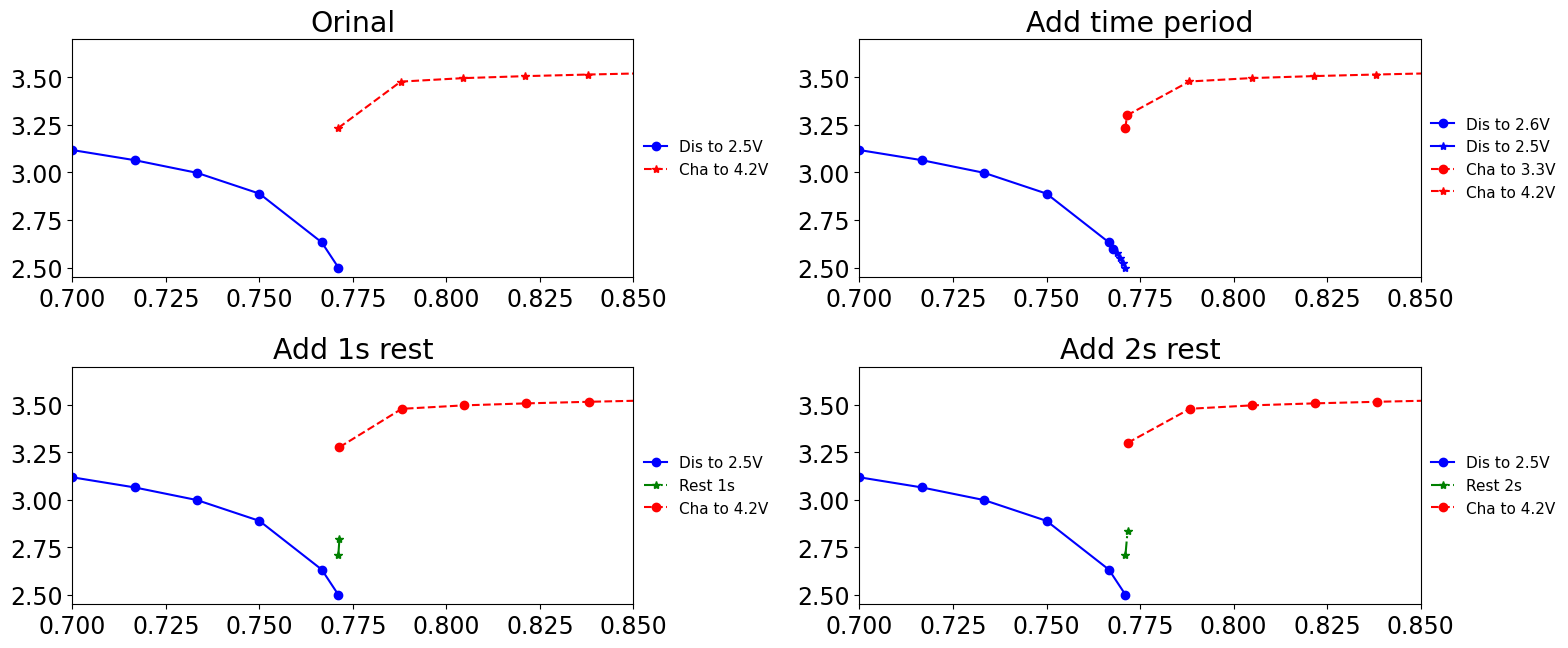

In [77]:
fig, axs = plt.subplots(2,2, figsize=(16,6.8),tight_layout=True)
axs = axs.flatten()
axs[0].plot(
    Sol_new_2.cycles[0].steps[0]["Time [h]"].entries,
    Sol_new_2.cycles[0].steps[0]["Terminal voltage [V]"].entries, 
    color='b',   linestyle='-',marker = 'o',
    label="Dis to 2.5V")
axs[0].plot(
    Sol_new_2.cycles[0].steps[1]["Time [h]"].entries,
    Sol_new_2.cycles[0].steps[1]["Terminal voltage [V]"].entries, 
    color='r',   linestyle='--',marker = '*',
    label="Cha to 4.2V")

axs[1].plot(
    Sol_new_3.cycles[0].steps[0]["Time [h]"].entries,
    Sol_new_3.cycles[0].steps[0]["Terminal voltage [V]"].entries, 
    color='b',   linestyle='-',marker = 'o',
    label="Dis to 2.6V")
axs[1].plot(
    Sol_new_3.cycles[0].steps[1]["Time [h]"].entries,
    Sol_new_3.cycles[0].steps[1]["Terminal voltage [V]"].entries,
    color='b',   linestyle='-',marker = '*',
    label="Dis to 2.5V")
axs[1].plot(
    Sol_new_3.cycles[0].steps[2]["Time [h]"].entries,
    Sol_new_3.cycles[0].steps[2]["Terminal voltage [V]"].entries, 
    color='r',   linestyle='--',marker = 'o',
    label="Cha to 3.3V")
axs[1].plot(
    Sol_new_3.cycles[0].steps[3]["Time [h]"].entries,
    Sol_new_3.cycles[0].steps[3]["Terminal voltage [V]"].entries, 
    color='r',   linestyle='--',marker = '*',
    label="Cha to 4.2V")

axs[2].plot(
    Sol_new_4.cycles[0].steps[0]["Time [h]"].entries,
    Sol_new_4.cycles[0].steps[0]["Terminal voltage [V]"].entries, 
    color='b',   linestyle='-',marker = 'o',
    label="Dis to 2.5V")
axs[2].plot(
    Sol_new_4.cycles[0].steps[1]["Time [h]"].entries,
    Sol_new_4.cycles[0].steps[1]["Terminal voltage [V]"].entries,
    color='g',   linestyle='-.',marker = '*',
    label="Rest 1s")
axs[2].plot(
    Sol_new_4.cycles[0].steps[2]["Time [h]"].entries,
    Sol_new_4.cycles[0].steps[2]["Terminal voltage [V]"].entries, 
    color='r',   linestyle='--',marker = 'o',
    label="Cha to 4.2V")

axs[3].plot(
    Sol_new_5.cycles[0].steps[0]["Time [h]"].entries,
    Sol_new_5.cycles[0].steps[0]["Terminal voltage [V]"].entries, 
    color='b',   linestyle='-',marker = 'o',
    label="Dis to 2.5V")
axs[3].plot(
    Sol_new_5.cycles[0].steps[1]["Time [h]"].entries,
    Sol_new_5.cycles[0].steps[1]["Terminal voltage [V]"].entries,
    color='g',   linestyle='-.',marker = '*',
    label="Rest 2s")
axs[3].plot(
    Sol_new_5.cycles[0].steps[2]["Time [h]"].entries,
    Sol_new_5.cycles[0].steps[2]["Terminal voltage [V]"].entries, 
    color='r',   linestyle='--',marker = 'o',
    label="Cha to 4.2V")

Titles = ["Orinal", "Add time period", "Add 1s rest","Add 2s rest"]
for i in range(4):
    axs[i].legend(prop={'family':'DejaVu Sans','size':fs-2},
        loc='center left',bbox_to_anchor=(1, 0.5),ncol=1,
        frameon=False,markerscale=1,borderpad=0.2,
        handlelength=1.5,columnspacing=1)
    axs[i].set_xlim(0.7,0.85)
    axs[i].set_ylim(2.45,3.7)
    axs[i].set_title(Titles[i])


In [118]:
Model_new.variables.search("Negative electrode stoichiometry")

Negative electrode stoichiometry
Positive electrode stoichiometry


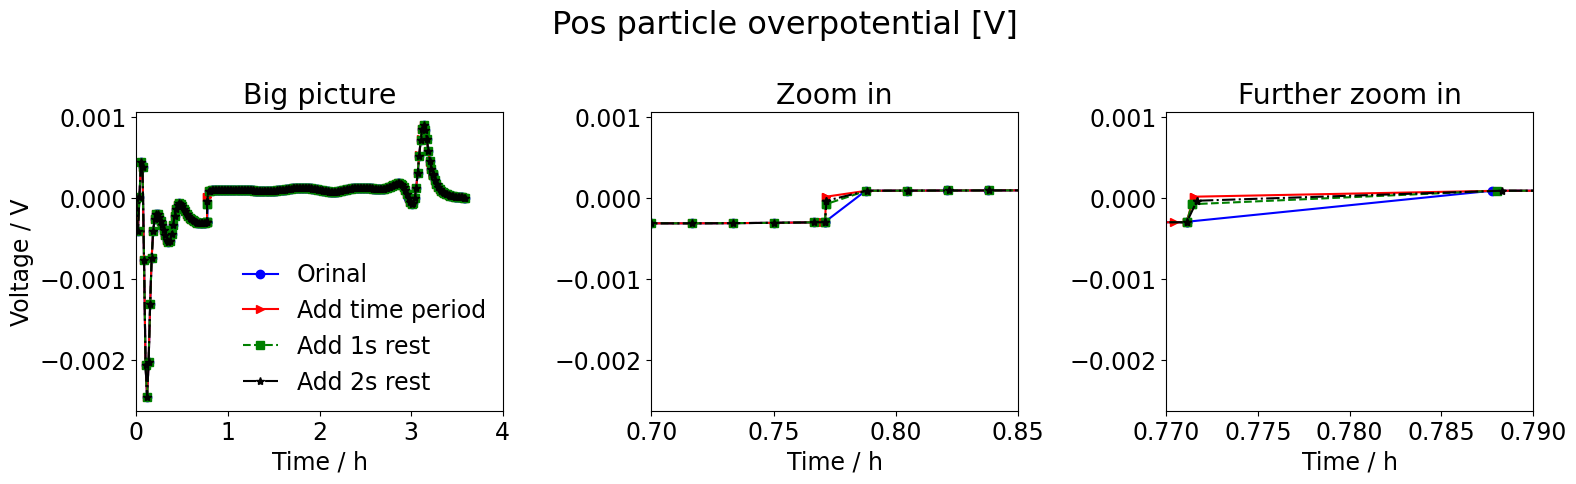

In [159]:
def Plot_compare_sols(Fig_title,key):
    fig, Axs = plt.subplots(1,3, figsize=(16,5),tight_layout=True)
    Titles = ["Orinal", "Add time period", "Add 1s rest","Add 2s rest"]
    for i in range(3):
        axs = Axs[i]
        axs.plot(
            Sol_new_2.cycles[0]["Time [h]"].entries,
            Sol_new_2.cycles[0][key].entries, 
            color='b',   linestyle='-',marker = 'o',
            label=Titles[0])

        axs.plot(
            Sol_new_3.cycles[0]["Time [h]"].entries,
            Sol_new_3.cycles[0][key].entries, 
            color='r',   linestyle='-',marker = '>',
            label=Titles[1])

        axs.plot(
            Sol_new_4.cycles[0]["Time [h]"].entries,
            Sol_new_4.cycles[0][key].entries, 
            color='g',   linestyle='--',marker = 's',
            label=Titles[2])

        axs.plot(
            Sol_new_5.cycles[0]["Time [h]"].entries,
            Sol_new_5.cycles[0][key].entries, 
            color='k',   linestyle='-.',marker = '*',label=Titles[3] )
        axs.set_xlabel("Time / h")
        
    Axs[0].set_xlim(0,4)
    Axs[1].set_xlim(0.7,0.85)
    
    Axs[2].set_xlim(0.77,0.79)
    
    Axs[0].legend(prop={'family':'DejaVu Sans','size':fs+4},
            frameon=False,markerscale=1,borderpad=0.2,
            handlelength=1.5,columnspacing=1)
    #axs.set_ylim(2.45,3.7)
    Axs[0].set_ylabel("Voltage / V")
    Axs[0].set_title("Big picture")
    Axs[1].set_title("Zoom in")
    Axs[2].set_title("Further zoom in")
    fig.suptitle(Fig_title, fontsize=fs+10)
    #Axs[1].set_ylim(2.45,3.6)
    #Axs[2].set_ylim(2.45,3.6)
    return 

Plot_compare_sols(
    "Pos particle overpotential [V]"    ,
    "Battery positive particle concentration overpotential [V]")

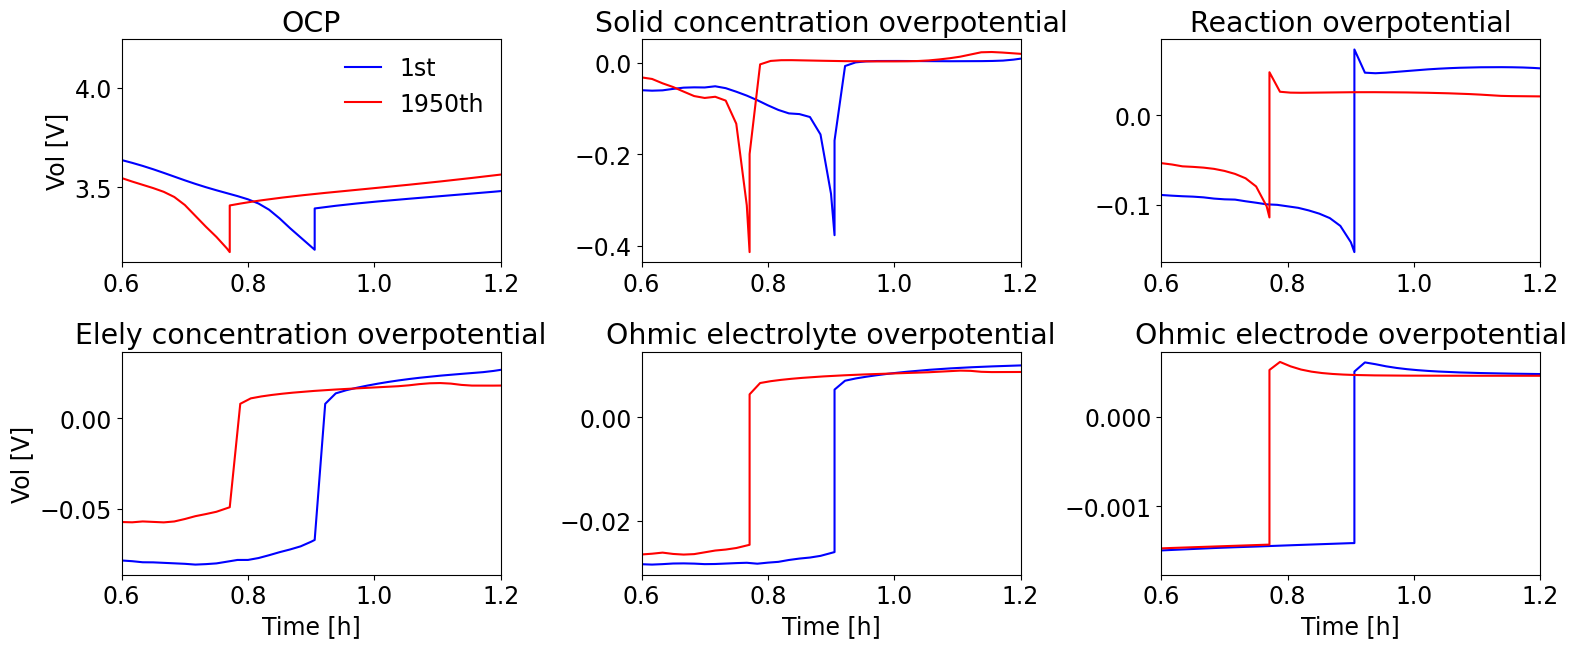

In [116]:
# now look at the voltage component of first and 1950 ageing cycles (original):
cyc_1st = Sol_AGE[0].cycles[0]
cyc_1950th = Sol_new_2.cycles[0]
Keys_v =  [
    'Battery open-circuit voltage [V]',
    "Battery particle concentration overpotential [V]",
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
]
Titles_2 = [
    "OCP",
    "Solid concentration overpotential",
    "Reaction overpotential",
    "Elely concentration overpotential",
    "Ohmic electrolyte overpotential",
    "Ohmic electrode overpotential",
]
fig, axs = plt.subplots(2,3, figsize=(16,6.8),tight_layout=True)
axs = axs.flatten()
for i in range(6):
    axs[i].plot(
        cyc_1st["Time [h]"].entries,
        cyc_1st[Keys_v[i]].entries, 
        color='b',   linestyle='-',marker = 'none',
        label="1st")
    axs[i].plot(
        cyc_1950th["Time [h]"].entries,
        cyc_1950th[Keys_v[i]].entries, 
        color='r',   linestyle='-',marker = 'none',
        label="1950th")
    axs[i].set_title(Titles_2[i])
    axs[i].set_xlim(0.6,1.2)


for i in np.arange(3,6):
    axs[i].set_xlabel("Time [h]")
axs[0].set_ylabel("Vol [V]")
axs[3].set_ylabel("Vol [V]")
axs[0].legend(prop={'family':'DejaVu Sans','size':fs+4},
    frameon=False,markerscale=1,borderpad=0.2,
    handlelength=1.5,columnspacing=1)

In [134]:
for i in range(len(Sol_AGE)):
    # print(int(i))
    print(Sol_AGE[int(i)])

Experiment error or infeasible


[0.29244862994104287, 0.29184045116343804, 0.2916787051330578, 0.29184238283398783, 0.2921944584222714, 0.2926565203155512, 0.2931956387153198, 0.29378853720519726, 0.2944217003584027, 0.29508998240386247, 0.295788906414772, 0.296515714299148, 0.2972682541199832, 0.2980458228478791, 0.2988478951374825, 0.29967161487175464, 0.3005095867538401, 0.3013589036637302, 0.3022276220346716, 0.3031170609655595, 0.3040193571174224, 0.30494638464260393, 0.3059044238748731, 0.3068843466064793, 0.3078958155006473]


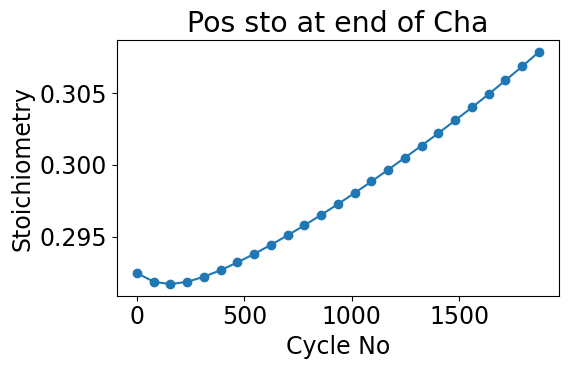

In [146]:
# neg_
"""     "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry", """
# cyc_1st = Sol_AGE[0].cycles[0]
def Plot_Electrode_sto(title):
    CDsta_Neg_SOC = []
    for i in range(len(Sol_AGE)-1):
        CDsta_Neg_SOC .append( 
            Sol_AGE[int(i)].cycles[0].steps[1]["Positive electrode stoichiometry"].entries[-1])
    print(CDsta_Neg_SOC)
    fig, axs = plt.subplots(figsize=(6,4),tight_layout=True)
    axs.plot(np.arange(0,len(Sol_AGE)-1)*78,  CDsta_Neg_SOC,"-o")
    axs.set_xlabel("Cycle No")
    axs.set_ylabel("Stoichiometry")
    axs.set_title(title)
    return 
Plot_Electrode_sto("Pos sto at end of Cha")

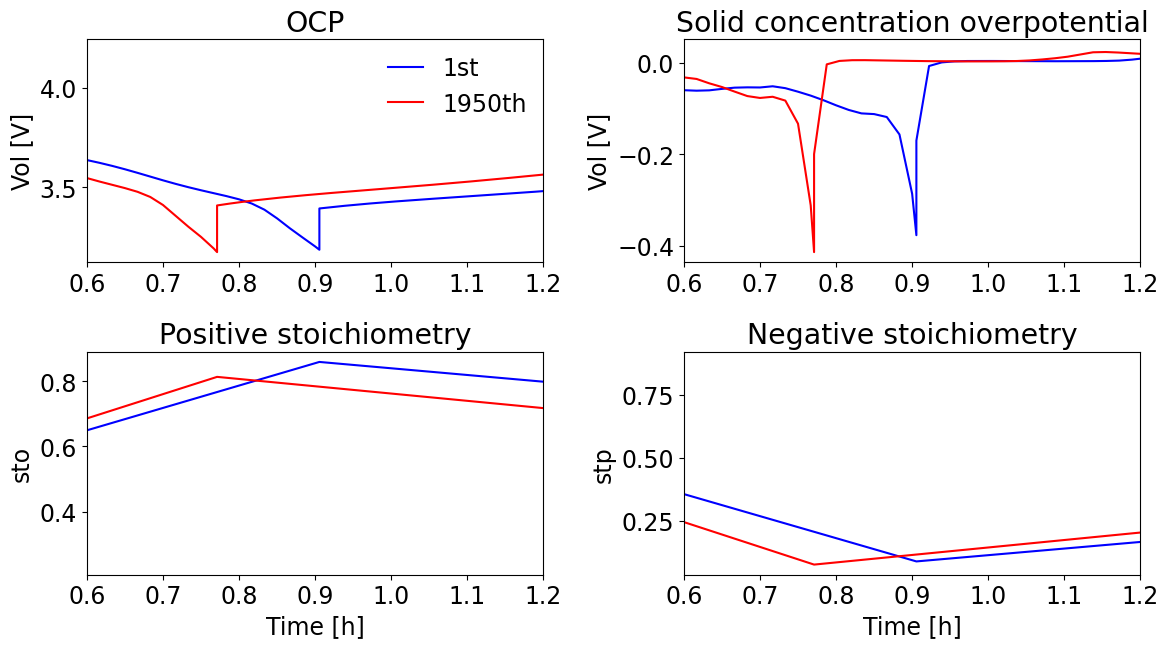

In [122]:
# check Positive electrode stoichiometry
cyc_1st = Sol_AGE[0].cycles[0]
cyc_1950th = Sol_new_2.cycles[0]
Keys_v =  [
    'Battery open-circuit voltage [V]',
    "Battery particle concentration overpotential [V]",
    "Positive electrode stoichiometry",
    "Negative electrode stoichiometry",
]
Titles_2 = [
    "OCP",
    "Solid concentration overpotential",
    "Positive stoichiometry",
    "Negative stoichiometry",
]
fig, axs = plt.subplots(2,2, figsize=(12,6.8),tight_layout=True)
axs = axs.flatten()
for i in range(4):
    axs[i].plot(
        cyc_1st["Time [h]"].entries,
        cyc_1st[Keys_v[i]].entries, 
        color='b',   linestyle='-',marker = 'none',
        label="1st")
    axs[i].plot(
        cyc_1950th["Time [h]"].entries,
        cyc_1950th[Keys_v[i]].entries, 
        color='r',   linestyle='-',marker = 'none',
        label="1950th")
    axs[i].set_title(Titles_2[i])
    axs[i].set_xlim(0.6,1.2)


for i in np.arange(2,4):
    axs[i].set_xlabel("Time [h]")
axs[0].set_ylabel("Vol [V]")
axs[1].set_ylabel("Vol [V]")
axs[2].set_ylabel("sto")
axs[3].set_ylabel("stp")
axs[0].legend(prop={'family':'DejaVu Sans','size':fs+4},
    frameon=False,markerscale=1,borderpad=0.2,
    handlelength=1.5,columnspacing=1)

In [86]:
print(Sol_new_2.cycles[77].steps[0]["Time [s]"].entries[-2:])
print(Sol_new_2.cycles[77].steps[0]["Terminal voltage [V]"].entries[-2:])

print(Sol_new_2.cycles[77].steps[1]["Time [s]"].entries[0:2])
print(Sol_new_2.cycles[77].steps[1]["Terminal voltage [V]"].entries[0:2])



# 
print(
    Sol_new_2.cycles[77].steps[1]["Time [s]"].entries[0] - 
    Sol_new_2.cycles[77].steps[0]["Time [s]"].entries[-1])
print(
    Sol_new_2.cycles[77].steps[1]["Terminal voltage [V]"].entries[0] - 
    Sol_new_2.cycles[77].steps[0]["Terminal voltage [V]"].entries[-1])

[997771.33277644 997783.18755948]
[2.6024426 2.50001  ]
[997783.18755948 997843.18755948]
[3.23467703 3.47857762]
1.0477378964424133e-09
0.7346670253292942


In [66]:
print(Sol_new_4.cycles[-1].steps[0]["Time [s]"].entries[-2:])
print(Sol_new_4.cycles[-1].steps[0]["Terminal voltage [V]"].entries[-2:])

print(Sol_new_4.cycles[-1].steps[1]["Time [s]"].entries)
print(Sol_new_4.cycles[-1].steps[1]["Terminal voltage [V]"].entries)

print(Sol_new_4.cycles[-1].steps[2]["Time [s]"].entries[0:2])
print(Sol_new_4.cycles[-1].steps[2]["Terminal voltage [V]"].entries[0:2])



[28626.30423447 28643.44639302]
[2.6402539 2.50001  ]
[28643.44639302 28644.44639302]
[2.71019093 2.79072055]
[28644.44639302 28704.44639302]
[3.27581428 3.47791818]


In [24]:

var3 = [
    "Porosity",
    "Electrolyte concentration [mol.m-3]",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(Sol_new_2.cycles[-1], var3,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=276.39203688234363, description='t', max=279.9785134989709, min=276.39…

84.08754799713353


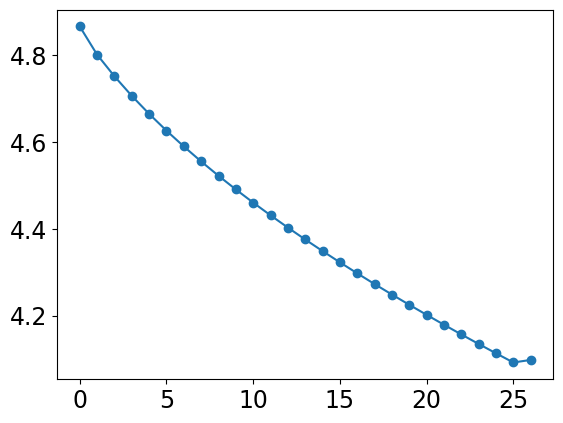

In [37]:
plt.plot(midc_merge["Discharge capacity [A.h]"],"-o") # Cyc_Update_Index
#midc_merge["Cyc_Update_Index"] 
print(midc_merge["Discharge capacity [A.h]"][-2]/midc_merge["Discharge capacity [A.h]"][0]*100)

In [8]:
# index_exp should be 1~5:
index_exp = 1; Plot_Exp = "haha"
if not index_exp in list(np.arange(1,6)):
    Plot_Exp = False
print(Plot_Exp)

haha


In [9]:
np.diff(np.array(midc_merge['Throughput capacity [kA.h]'])*1e3)

array([731.21762533, 722.66207749, 714.99014351, 708.04300899,
       701.66003847, 695.67503103, 690.01179961, 684.66830548,
       679.5696969 , 674.6495404 , 669.93876236, 665.41350952,
       661.00485464, 656.71802759, 652.58552949, 648.55532581,
       644.590254  , 640.74210591, 637.00673175, 633.32115327,
       629.68906846, 626.15724455, 622.68993968, 619.25616925,
       615.90754808,  23.98552261])

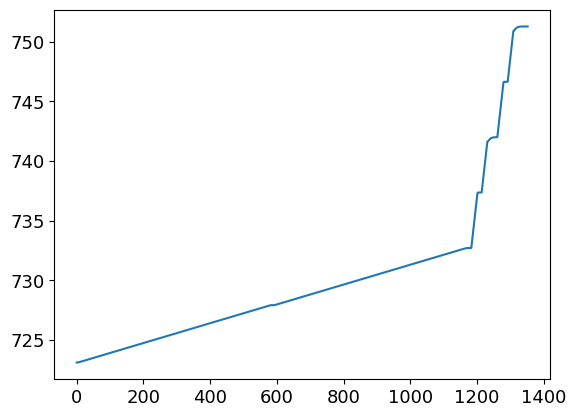

In [10]:
plt.plot(Sol_RPT[1]['Throughput capacity [A.h]'].entries)

In [11]:
print(Sol_RPT[1]['Throughput capacity [A.h]'].entries  - Sol_RPT[1]['Throughput capacity [A.h]'].entries[0] )
print(Sol_RPT[0]['Throughput capacity [A.h]'].entries  - Sol_RPT[0]['Throughput capacity [A.h]'].entries[0] )

[ 0.          0.          0.         ... 28.18023955 28.18023955
 28.18023955]
[0.00000000e+00 5.23194956e-03 8.53127085e-03 ... 2.00742477e+01
 2.00742477e+01 2.00742477e+01]


In [12]:

# note: this is only precise for Exp-2, for Exp-3 there might be bigger issue.
def Get_Throughput_cap(sol,save_as_cycle): 
    if save_as_cycle==1:
        thr_tot = (
            sol['Throughput capacity [A.h]'].entries[-1]
            -sol['Throughput capacity [A.h]'].entries[0]) 
    else:
        # Get average of first and last:
        cyc_number = len(sol.cycles)
        thr_1st = np.trapz(
            abs(sol.cycles[0]["Current [A]"].entries), 
            sol.cycles[0]["Time [h]"].entries) # in A.h
        thr_end = np.trapz(
            abs(sol.cycles[-1]["Current [A]"].entries), 
            sol.cycles[-1]["Time [h]"].entries) # in A.h
        thr_tot = (thr_1st+thr_end) / 2 * cyc_number
        # print(thr_1st,thr_end,thr_tot)
    return thr_tot
Get_Throughput_cap(Sol_AGE[-1],516)

AttributeError: 'str' object has no attribute 'cycles'

In [ ]:
Get_Throughput_cap(Sol_RPT[0],1)
Sol_RPT[0]['Throughput capacity [A.h]'].entries

In [ ]:
Sol_AGE[0]['Throughput capacity [A.h]'].entries[-1] 
Sol_AGE[0]['Throughput capacity [A.h]'].entries[-1]  = 100
Sol_AGE[0]['Throughput capacity [A.h]'].entries[-1] 

In [ ]:
plt.plot(Sol_RPT[0]["Time [h]"].entries)

In [ ]:

fig, axs = plt.subplots(3,1,figsize=(6,10),tight_layout=True) 
axs[0].plot(Sol_RPT[1]["Time [h]"].entries,Sol_RPT[1]["Terminal voltage [V]"].entries,'-o')
axs[1].plot(Sol_RPT[1]["Time [h]"].entries,Sol_RPT[1]["Current [A]"].entries,'-o')
axs[2].plot(Sol_RPT[1]["Time [h]"].entries,Sol_RPT[1]["Throughput capacity [A.h]"].entries-Sol_RPT[1]["Throughput capacity [A.h]"].entries[0],'-o')

In [ ]:
plt.plot(Sol_AGE[1]["Time [h]"].entries,Sol_AGE[0]["Terminal voltage [V]"].entries,'-o')

In [ ]:
(0.7297365+0.5339990778626663)*516
0.7297365*2*518
print(len(Sol_AGE),len(Sol_RPT),)

In [ ]:
def Plot_sol(sol):
    # step-1: get and plot discharge capacity vs throughput capacity 
    fig, axs = plt.subplots( figsize=(6,4),tight_layout=True) 
    axs.plot(sol["Time [h]"].entries,sol["Discharge capacity [A.h]"].entries,'-o')
    axs.plot(sol["Time [h]"].entries,sol["Throughput capacity [A.h]"].entries-sol["Throughput capacity [A.h]"].entries[0],'-o')
    thr_cap_1 = sol["Throughput capacity [A.h]"].entries[-1]-sol["Throughput capacity [A.h]"].entries[0]
    thr_cap_2 = np.trapz(abs(sol["Current [A]"].entries), sol["Time [h]"].entries) # in A.h
    print(thr_cap_1,thr_cap_2)
    return thr_cap_1,thr_cap_2
cap_acc = 0
for i in range(2):
    thr_cap_1,thr_cap_2 = Plot_sol(Sol_AGE[i])
    cap_acc +=  thr_cap_1
for i in range(3):
    thr_cap_1,thr_cap_2 = Plot_sol(Sol_RPT[i])
    cap_acc +=  thr_cap_1
print(cap_acc)

In [ ]:
thr_cap_1,thr_cap_2 = Plot_sol(Sol_AGE[0].cycles[0])
thr_cap_3,thr_cap_4 = Plot_sol(Sol_AGE[0].cycles[-1])
print((thr_cap_1+thr_cap_3)/2*516)

In [ ]:
plt.plot(Sol_RPT[0]["Time [h]"].entries,Sol_RPT[0]["Discharge capacity [A.h]"].entries,'-o')
plt.plot(Sol_RPT[1]["Time [h]"].entries,Sol_RPT[1]["Discharge capacity [A.h]"].entries,'--')
plt.plot(Sol_RPT[2]["Time [h]"].entries,Sol_RPT[2]["Discharge capacity [A.h]"].entries,'--')

In [ ]:
plt.plot(Sol_AGE[1]["Time [h]"].entries,Sol_AGE[0]["Throughput capacity [A.h]"].entries,'-o')

In [ ]:
# Sol_0[0].cycles[-1]["Negative electrode stoichiometry"].entries
#label = ["Diff_Li_SEI = 1e-18","Diff_Li_SEI = 1e-16"] 
vars = [
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(
    Sol_0[0].cycles[-1], 
    vars,variable_limits='tight') #     
quick_plot.dynamic_plot();

In [ ]:
Sol_0[-2].cycles

In [ ]:
vars = [
    "Negative electrode stoichiometry",
    "Positive electrode stoichiometry",
    "SEI interfacial current density [A.m-2]",
    "Negative particle surface concentration [mol.m-3]",
    
]
quick_plot = pb.QuickPlot(
    Sol_0[-1].cycles[0], 
    vars,variable_limits='tight') #     
quick_plot.dynamic_plot();